In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
#read in game information
steam = pd.read_csv("./steam_all/steam_all_last_attempt.csv")

In [4]:
steam1 = steam

In [5]:
steam1.shape

(6902, 17)

In [6]:
steam1.columns

Index([u'main_link', u'no_user', u'title', u'url', u'mother_node', u'app_id',
       u'publish', u'user_rating', u'keywords', u'Rdate', u'critics_review',
       u'genre', u'list_title', u'desc', u'type', u'no_links', u'game_spcs'],
      dtype='object')

In [7]:
steam1["no_user"][0]

'\r\n\t\t\t\t\t\t\t\t\t\t\t\t- 92% of the 419 user reviews for this game are positive.\t\t\t\t\t\t\t\t\t\t\t'

In [8]:
steam1["no_user"] = steam1["no_user"].str.strip()

In [9]:
#grabbing percentage of positive reviews
steam1["percent"] = steam1["no_user"].str.extract("- (\d{2,3})\% .+")

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [10]:
steam1["percent"] = pd.to_numeric(steam1["percent"])

In [11]:
#grabbing number of reviews
steam1["reivew_users"]=pd.to_numeric(steam1["no_user"].str.extract("- \d{2,3}\% of the (.+) user .+").str.replace(",",""))

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [12]:
#construct a keyword list without extra spaces and lines
for i in range(steam1.shape[0]):
    steam1.loc[i,"keywords_list"] = ', '.join(map(lambda x: x.strip(),str(steam1["keywords"][i]).split(",")))

In [13]:
steam1["type"].value_counts()

None                    4263
Downloadable Content    2628
not_found                 11
Name: type, dtype: int64

In [14]:
#checking if original game differs from title - these should match with DLC and other type
for i in range(steam1.shape[0]):
    if steam1.loc[i,"title"] != steam1.loc[i,"mother_node"]:
        steam1.loc[i,"sub"] = 1

In [15]:
#identifying listing that are not downloadable content but has a different original game
for i in range(steam1.shape[0]):
    if (steam1.loc[i,"sub"] == 1)&(steam1.loc[i,"type"]!="Downloadable Content"):
        steam1.loc[i,"dlc_notsub"] = 1

In [16]:
#review user rating
steam1["user_rating"].value_counts()

not-found                  2913
Very Positive              1984
Mostly Positive             883
Positive                    879
Overwhelmingly Positive     243
Name: user_rating, dtype: int64

In [18]:
#assign not-found to NaN
steam1.replace("not-found",np.NaN, inplace=True)

In [19]:
#extracting genres from a list that includes both publishers and producers
for i in range(steam1.shape[0]):
    steam1.loc[i,"genre_list"] = ", ".join(list(set(str(steam1["genre"][i]).split(","))^set(str(steam1["publish"][i]).split(","))))

In [20]:
#size of the dataset
steam1.shape

(6902, 23)

In [21]:
steam1["type"].value_counts()

None                    4263
Downloadable Content    2628
not_found                 11
Name: type, dtype: int64

In [22]:
#the final dataset should only consist of original games - soundtracks and downloadable content information
# will be added to the original game
a = steam1[(steam1["type"]=="None")].groupby("mother_node").first().reset_index()

In [23]:
a.shape

(4165, 23)

In [24]:
a.rename(columns={"title":"title_steam"},inplace=True)

In [25]:
#creating a database to count the number of DLCs
downloadable = steam1.loc[steam1["type"]=="Downloadable Content"]

In [26]:
downloadable['type'].value_counts()

Downloadable Content    2628
Name: type, dtype: int64

In [27]:
downloadable.columns

Index([u'main_link', u'no_user', u'title', u'url', u'mother_node', u'app_id',
       u'publish', u'user_rating', u'keywords', u'Rdate', u'critics_review',
       u'genre', u'list_title', u'desc', u'type', u'no_links', u'game_spcs',
       u'percent', u'reivew_users', u'keywords_list', u'sub', u'dlc_notsub',
       u'genre_list'],
      dtype='object')

In [28]:
dlc_count = downloadable[["title","mother_node"]].groupby("mother_node").agg(["count"])

In [29]:
dlc_count1 = dlc_count.reset_index()

In [30]:
#making sure that there is no repating values
dlc_count1.columns = dlc_count1.columns.get_level_values(0)

In [31]:
dlc_count1.rename(columns={'title':'no_dlc'}, inplace=True)
dlc_count1.rename(columns={'mother_node':'mother_dlc'}, inplace=True)

In [32]:
dlc_count1.columns

Index([u'mother_dlc', u'no_dlc'], dtype='object')

In [33]:
dlc_count1.shape

(665, 2)

In [34]:
a.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list'],
      dtype='object')

In [35]:
#adding number of dlc in the 
games_dlc=pd.merge(a, dlc_count1, how="left", left_on = "mother_node", right_on = "mother_dlc")

In [36]:
for i in range(games_dlc.shape[0]):
    if pd.isnull(games_dlc.loc[i, "no_dlc"])==True:
        games_dlc.loc[i,"no_dlc"] = 0

In [37]:
games_dlc.loc[games_dlc["no_dlc"]>=1,"dlc_av"] = 1
games_dlc.loc[games_dlc["no_dlc"]==0,"dlc_av"] = 0

In [38]:
games_dlc["dlc_av"].value_counts()

0.0    3684
1.0     481
Name: dlc_av, dtype: int64

In [39]:
games_dlc.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av'],
      dtype='object')

In [40]:
games_dlc.shape

(4165, 26)

In [41]:
#reading in data on top seller ranking and price
steam_rank = pd.read_csv("./ranking and price/ranking_withprice.csv")

In [42]:
steam_rank.shape

(7827, 3)

In [43]:
# revmoing duplicate records - I found out that the original steam listing consisted of repeating records of the same game
# while the ranking is different, the price is the same.
steam_rank_no = steam_rank[["title","rank_no"]].sort_values(by = "rank_no").groupby(by="title").first().reset_index()

In [44]:
steam_rank_no.head(3)

,title,rank_no
0,,6413
1,- Red Obsidian Remnant,3567
2,Double Oik!,3275


In [45]:
steam_rank_no.loc[0,"title"]=""

In [46]:
steam_rank_no.shape

(7642, 2)

In [47]:
# clearning up price data
steam_rank["price"] = steam_rank["price"].str.strip()

In [48]:
for i in range(len(steam_rank)):
    if type(steam_rank.loc[i,"price"]) is str:
        if steam_rank.loc[i,"price"] == "Free":
            steam_rank.loc[i,"price"] = 0
        else:
            steam_rank.loc[i,"price"] = float(steam_rank.loc[i,"price"])
    else:
        steam_rank.loc[i,"price"] = np.NaN

In [49]:
steam_rank[["title","price"]].head(5)

,title,price
0,Prey,59.99
1,PLAYERUNKNOWN'S BATTLEGROUNDS,29.99
2,Rocket League,13.99
3,Star Wars Complete Collection,60.68
4,Sid Meiers Civilization VI,40.19


In [50]:
sum(pd.isnull(steam_rank["price"]))

0

In [51]:
steam_rank["price"]=steam_rank["price"].astype(float)

In [52]:
#removing duplicates
steam_price = steam_rank[["title","price"]].groupby("title").agg("mean")

In [53]:
steam_price = steam_price.reset_index()

In [54]:
steam_price.shape

(7642, 2)

In [55]:
#creating a df with unique price and rank
steam_price_rank = pd.merge(steam_price, steam_rank_no,how = "inner",left_on = "title", right_on= "title")

In [56]:
steam_price_rank.shape

(7641, 3)

In [57]:
# extracting game and original game relationship from the game information df
steam_name = steam1[["mother_node","title"]]

In [58]:
steam_name = steam_name.drop_duplicates()

In [59]:
steam_name.shape

(6763, 2)

In [60]:
steam_name.columns

Index([u'mother_node', u'title'], dtype='object')

In [61]:
steam_price_rank.columns

Index([u'title', u'price', u'rank_no'], dtype='object')

In [62]:
#merge rank and price with game and oritinal game mapping 
ranking = pd.merge(steam_name, steam_price_rank, how="inner",left_on="title",right_on="title")

In [63]:
ranking.shape

(6259, 4)

In [64]:
ranking = ranking.sort_values("rank_no")

In [65]:
#removing duplicate games 
ranking_mother = ranking.groupby("mother_node").first().reset_index()

In [66]:
ranking_mother.head(3)

,mother_node,title,price,rank_no
0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567
1,"""BUTTS: The VR Experience""","""BUTTS: The VR Experience""",0.99,7504
2,#Archery,#Archery,9.99,5477


In [67]:
ranking_mother.shape

(4067, 4)

In [68]:
ranking_mother.columns

Index([u'mother_node', u'title', u'price', u'rank_no'], dtype='object')

In [69]:
games_dlc.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av'],
      dtype='object')

In [70]:
ranking_mother.rename(columns={'mother_node':'mother_rank','title':'title_rank'}, inplace=True)

In [71]:
#merging information back to the unique game df
rank = pd.merge(games_dlc, ranking_mother, how = "inner", left_on = "mother_node", right_on = "mother_rank")

In [72]:
rank.shape

(3899, 30)

In [73]:
sum(pd.isnull(rank["rank_no"]))

0

In [74]:
sum(pd.isnull(rank["Rdate"]))

8

In [75]:
rank.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no'],
      dtype='object')

In [76]:
#adding information regarding current player no, and all time high
steam_player = pd.read_csv("./player_count/users1.csv")

In [77]:
steam_player.shape

(8061, 5)

In [78]:
steam_player.columns

Index([u'current', u'all_time', u'app_id', u'day', u'title'], dtype='object')

In [79]:
steam_app = steam1[["mother_node","title","app_id"]]

In [80]:
steam_app = steam_app.drop_duplicates()

In [81]:
steam_app.head(5)

,mother_node,title,app_id
0,Prey,Prey,480490
1,Tales of Berseria,Tales of Berseria,429660
2,RESIDENT EVIL 7 biohazard / BIOHAZARD 7 reside...,RESIDENT EVIL 7 biohazard / BIOHAZARD 7 reside...,418370
3,Dragon's Dogma: Dark Arisen,Dragon's Dogma: Dark Arisen,367500
4,Tom Clancy's Ghost Recon Wildlands,Tom Clancy's Ghost Recon Wildlands,460930


In [82]:
#adding original game and game mapping information
name_player = pd.merge(steam_player, steam_app, how="inner",left_on = "app_id",right_on = "app_id")

In [83]:
name_player.columns

Index([u'current', u'all_time', u'app_id', u'day', u'title_x', u'mother_node',
       u'title_y'],
      dtype='object')

In [84]:
name_player.shape

(3311, 7)

In [85]:
#converting player stats into numeric
name_player["all_time"] = pd.to_numeric(name_player["all_time"].str.replace(",",""))

In [86]:
for i in range(len(name_player)):
    name_player.loc[i,"current"] = float(name_player.loc[i,"current"])

In [87]:
name_player["day"] = pd.to_numeric(name_player["day"].str.replace(",",""))

In [88]:
#creating a mean number of player for each original game
name_player_avg = name_player.groupby('mother_node').agg("mean").reset_index()

In [89]:
name_player_avg.head(5)

,mother_node,current,all_time,app_id,day
0,,1.0,27.0,562210.0,7.0
1,- Red Obsidian Remnant,9.0,290.0,610960.0,127.0
2,#Archery,1.0,7.0,493790.0,2.0
3,#SelfieTennis,1.0,17.0,392190.0,3.0
4,$1 Ride,7.0,862.0,508290.0,70.0


In [90]:
cols = pd.MultiIndex.from_tuples([("mean", "mother_node"), ("mean", "current"),("mean","all_time"),("mean","app_id"),("mean","24_peak")])

In [91]:
name_player_avg.columns = cols

In [92]:
name_player_avg.columns = name_player_avg.columns.droplevel()

In [93]:
name_player_avg.head(5)

,mother_node,current,all_time,app_id,24_peak
0,,1.0,27.0,562210.0,7.0
1,- Red Obsidian Remnant,9.0,290.0,610960.0,127.0
2,#Archery,1.0,7.0,493790.0,2.0
3,#SelfieTennis,1.0,17.0,392190.0,3.0
4,$1 Ride,7.0,862.0,508290.0,70.0


In [94]:
name_player_avg.columns

Index([u'mother_node', u'current', u'all_time', u'app_id', u'24_peak'], dtype='object')

In [95]:
name_player_avg  = name_player_avg[["mother_node","current","all_time","24_peak"]]

In [544]:
#adding inforamtion back together
final_player = pd.merge(rank, name_player_avg, how = "inner",left_on = "mother_node", right_on = "mother_node")

In [545]:
final_player.shape

(3080, 33)

In [546]:
final_player.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no', u'current', u'all_time', u'24_peak'],
      dtype='object')

In [547]:
final_player.head(2)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,critics_review,genre,list_title,desc,type,no_links,game_spcs,percent,reivew_users,keywords_list,sub,dlc_notsub,genre_list,mother_dlc,no_dlc,dlc_av,mother_rank,title_rank,price,rank_no,current,all_time,24_peak
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",NaN,"Action,Adventure,Indie,RPG,Early Access,Red Ob...",红石遗迹 - Red Obsidian Remnant,\r\n\t\t\t\t\t\t\t\tA Roguelike gameplay and a...,None,3,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...",NaN,NaN,"Indie, Adventure, RPG, Action, Early Access",NaN,0.0,0.0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0
1,#Archery,http://store.steampowered.com/app/493790/?snr=...,- Need more user reviews to generate a score,#Archery,http://store.steampowered.com/app/493790/Arche...,493790,"VRUnicorns,Bandello",NaN,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Mar 30, 2017",NaN,"Indie,Sports,Early Access,VRUnicorns,Bandello",#Archery,\r\n\t\t\t\t\t\t\t\t#Archery brings out your i...,None,3,"Single-player,Local Multi-Player,Steam Achieve...",NaN,NaN,"Early Access, Indie, Sports, VR",NaN,NaN,"Indie, Early Access, Sports",NaN,0.0,0.0,#Archery,#Archery,9.99,5477,1.0,7.0,2.0


In [548]:
sum(pd.isnull(final_player["Rdate"]))

4

In [549]:
final_player["str_date"] = final_player["Rdate"].str.contains(",")

In [550]:
#cleaning up the release date format
for i in range(len(final_player)):
    if final_player.loc[i, "str_date"] is True:
        final_player.loc[i,"DATE"] = pd.to_datetime(final_player.loc[i,"Rdate"], format = "%b %d, %Y")
    else:
        final_player.loc[i,"DATE"] = pd.to_datetime(final_player.loc[i,"Rdate"], format = "%b %Y")

In [551]:
final_player.head(2)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,critics_review,genre,list_title,desc,type,no_links,game_spcs,percent,reivew_users,keywords_list,sub,dlc_notsub,genre_list,mother_dlc,no_dlc,dlc_av,mother_rank,title_rank,price,rank_no,current,all_time,24_peak,str_date,DATE
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",NaN,"Action,Adventure,Indie,RPG,Early Access,Red Ob...",红石遗迹 - Red Obsidian Remnant,\r\n\t\t\t\t\t\t\t\tA Roguelike gameplay and a...,None,3,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...",NaN,NaN,"Indie, Adventure, RPG, Action, Early Access",NaN,0.0,0.0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0,True,2017-04-20
1,#Archery,http://store.steampowered.com/app/493790/?snr=...,- Need more user reviews to generate a score,#Archery,http://store.steampowered.com/app/493790/Arche...,493790,"VRUnicorns,Bandello",NaN,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Mar 30, 2017",NaN,"Indie,Sports,Early Access,VRUnicorns,Bandello",#Archery,\r\n\t\t\t\t\t\t\t\t#Archery brings out your i...,None,3,"Single-player,Local Multi-Player,Steam Achieve...",NaN,NaN,"Early Access, Indie, Sports, VR",NaN,NaN,"Indie, Early Access, Sports",NaN,0.0,0.0,#Archery,#Archery,9.99,5477,1.0,7.0,2.0,True,2017-03-30


In [552]:
final_player.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no', u'current', u'all_time', u'24_peak', u'str_date', u'DATE'],
      dtype='object')

In [553]:
import datetime
datetime.date.today()

datetime.date(2017, 5, 7)

In [554]:
#computing time since game released
final_player["time_diff"] = (datetime.date.today() - final_player["DATE"])

In [555]:
final_player.head(1)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,critics_review,genre,list_title,desc,type,no_links,game_spcs,percent,reivew_users,keywords_list,sub,dlc_notsub,genre_list,mother_dlc,no_dlc,dlc_av,mother_rank,title_rank,price,rank_no,current,all_time,24_peak,str_date,DATE,time_diff
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",NaN,"Action,Adventure,Indie,RPG,Early Access,Red Ob...",红石遗迹 - Red Obsidian Remnant,\r\n\t\t\t\t\t\t\t\tA Roguelike gameplay and a...,None,3,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...",NaN,NaN,"Indie, Adventure, RPG, Action, Early Access",NaN,0.0,0.0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0,True,2017-04-20,17 days


In [556]:
final_player.columns.values

array(['mother_node', 'main_link', 'no_user', 'title_steam', 'url',
       'app_id', 'publish', 'user_rating', 'keywords', 'Rdate',
       'critics_review', 'genre', 'list_title', 'desc', 'type', 'no_links',
       'game_spcs', 'percent', 'reivew_users', 'keywords_list', 'sub',
       'dlc_notsub', 'genre_list', 'mother_dlc', 'no_dlc', 'dlc_av',
       'mother_rank', 'title_rank', 'price', 'rank_no', 'current',
       'all_time', '24_peak', 'str_date', 'DATE', 'time_diff'], dtype=object)

In [557]:
for i in range(len(final_player)):
    final_player.loc[i,"YEAR"] = final_player.loc[i,"DATE"].year

In [558]:
#selecting cleaned up variables
final_file = final_player[["mother_node","title_steam","app_id","user_rating","game_spcs","percent","reivew_users","keywords_list","genre_list","no_dlc","dlc_av","rank_no","current","all_time","24_peak","time_diff","YEAR","price"]]

In [559]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99


In [560]:
final_file.shape

(3080, 18)

In [561]:
keyword_dict = dict()

In [562]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price'], dtype=object)

In [563]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99


In [564]:
#creating a unique keyword list that does not include genre words
def unique(x, y):
    a = x.split(', ') 
    b = y.split(', ')
    unique = list(set(a)-set(b))
    unique = ", ".join(unique)
    return unique
final_file.loc[:,"unique"] = np.vectorize(unique)(final_file["keywords_list"], final_file["genre_list"])

In [565]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,unique
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99,Rogue-like


In [566]:
#count top keywords
keyword_dict= dict()
for i in range(len(final_file)):
    a = final_file.loc[i,"unique"].split(", ")
    for i in a:
        if i not in keyword_dict:
            keyword_dict[i] = 1
        if i in keyword_dict:
            keyword_dict[i] = keyword_dict[i] + 1

In [567]:
key = pd.DataFrame(keyword_dict.items(),columns = ["keywords","count"]).sort_values("count",ascending= False)

In [568]:
key.head(30)

,keywords,count
66,Singleplayer,1665
246,Multiplayer,875
46,Great Soundtrack,821
197,Atmospheric,746
36,Story Rich,524
82,Open World,522
51,2D,518
176,Co-op,510
264,Sci-fi,451
40,Adventure,433


In [569]:
genre_dict= dict()
for i in range(len(final_file)):
    a = final_file.loc[i,"genre_list"].split(", ")
    for i in a:
        if i not in genre_dict:
            genre_dict[i] = 1
        if i in genre_dict:
            genre_dict[i] = genre_dict[i] + 1

In [570]:
b = pd.DataFrame(genre_dict.items(),columns = ["genre","count"]).sort_values("count",ascending= False)

In [571]:
b[b["count"] > 100]

,genre,count
19,Indie,1727
14,Action,1402
8,Adventure,1120
15,Strategy,726
13,Simulation,658
9,RPG,655
25,Casual,630
16,Early Access,327
1,Sports,119
22,Violent,106


In [580]:
#creating dummy variable for top genres
def genre_recode(x,text):
    a = x.split(', ')
    if text in a:
        return 1
    else:
        return 0
final_file.loc[:,"Indie"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Indie'))
final_file.loc[:,"Action_g"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Action'))
final_file.loc[:,"Adventure_g"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Adventure'))
final_file.loc[:,"Strategy"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Strategy'))
final_file.loc[:,"Simulation"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Simulation'))
final_file.loc[:,"RPG"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'RPG'))
final_file.loc[:,"Casual"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Casual'))
final_file.loc[:,"Early Access"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Early Access'))
final_file.loc[:,"Sports"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Sports'))
final_file.loc[:,"Violent"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Violent'))
final_file.loc[:,"Racing"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Racing'))

In [582]:
# checking if if-statements worked
final_file.head(1)[["genre_list","Indie","Adventure_g","Racing","RPG","Action_g","Violent"]]

,genre_list,Indie,Adventure_g,Racing,RPG,Action_g,Violent
0,"Indie, Adventure, RPG, Action, Early Access",1,1,0,1,1,0


In [176]:
np.sum(final_file.Indie)

1726

In [583]:
#creating dummy variables for top keywords
def unique_recode(x,text):
    a = x.split(', ')
    if text in a:
        return 1
    else:
        return 0
final_file.loc[:,"Singleplayer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Singleplayer'))
final_file.loc[:,"Multiplayer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Multiplayer'))
final_file.loc[:,"Great Soundtrack"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Great Soundtrack'))
final_file.loc[:,"Atmospheric"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Atmospheric'))
final_file.loc[:,"Story Rich"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Story Rich'))
final_file.loc[:,"Open World"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Open World'))
final_file.loc[:,"2D"] = final_file["unique"].apply(lambda dic: unique_recode(dic, '2D'))
final_file.loc[:,"Co-op"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Co-op'))
final_file.loc[:,"Sci-fi"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Sci-fi'))
final_file.loc[:,"Adventure_k"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Adventure'))
final_file.loc[:,"Fantasy"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Fantasy'))
final_file.loc[:,"Puzzle"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Puzzle'))
final_file.loc[:,"First-Person"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'First-Person'))
final_file.loc[:,"Shooter"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Shooter'))
final_file.loc[:,"Difficult"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Difficult'))
final_file.loc[:,"Funny"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Funny'))
final_file.loc[:,"Classic"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Classic'))
final_file.loc[:,"Sandbox"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Sandbox'))
final_file.loc[:,"Horror"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Horror'))
final_file.loc[:,"Female Protagonist"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Female Protagonist'))
final_file.loc[:,"FPS"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'FPS'))
final_file.loc[:,"Pixel Graphics"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Pixel Graphics'))
final_file.loc[:,"Comedy"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Comedy'))
final_file.loc[:,"Survival"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Survival'))
final_file.loc[:,"Third Person"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Third Person'))
final_file.loc[:,"Anime"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Anime'))
final_file.loc[:,"Platformer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Platformer'))
final_file.loc[:,"Action_k"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Action'))
final_file.loc[:,"Turn-Based"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Turn-Based'))
final_file.loc[:,"Exploration"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Exploration'))


In [584]:
final_file.head(6)[["unique","Singleplayer","Anime","Fantasy"]]

,unique,Singleplayer,Anime,Fantasy
0,Rogue-like,0,0,0
1,VR,0,0,0
2,,0,0,0
3,"CRPG, Dating Sim, Singleplayer, Martial Arts, ...",1,0,0
4,"CRPG, Singleplayer, Romance, Anime, Historical...",1,1,0
5,"Character Customization, Fantasy, RPGMaker, St...",0,0,1


In [585]:
np.sum(final_file["Singleplayer"])

1664

In [586]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'unique', 'Singleplayer', 'Multiplayer',
       'Great Soundtrack', 'Atmospheric', 'Story Rich', 'Open World', '2D',
       'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy', 'Puzzle',
       'First-Person', 'Shooter', 'Difficult', 'Funny', 'Classic',
       'Sandbox', 'Horror', 'Female Protagonist', 'FPS', 'Pixel Graphics',
       'Comedy', 'Survival', 'Third Person', 'Anime', 'Platformer',
       'Action_k', 'Turn-Based', 'Exploration', 'total_key', 'Indie',
       'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing'], dtype=object)

In [587]:
for i in range(len(final_file)):
    a = final_file.loc[i,"keywords_list"].split(", ")
    final_file.loc[i,"total_key"] = len(a)

In [588]:
final_file.head(2)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,unique,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,...,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99,Rogue-like,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1,1,1,0,0,1,0,1,0,0,0
1,#Archery,#Archery,493790,NaN,"Single-player,Local Multi-Player,Steam Achieve...",NaN,NaN,"Early Access, Indie, Sports, VR","Indie, Early Access, Sports",0.0,0.0,5477,1.0,7.0,2.0,38 days,2017.0,9.99,VR,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,0,0,0,0,0,0,1,1,0,0


In [522]:
#calculating agreement
def agreement(x, y):
    a = x.split(', ') 
    b = y.split(', ')
    total = list(set(a+b))
    agree = list(set(a).intersection(b))
    agreement = float(len(agree))/float(len(total))
    return agreement
final_file.loc[:,"agreement"] = np.vectorize(agreement)(final_file["keywords_list"], final_file["genre_list"])

In [650]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,unique,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Adventure_k,Fantasy,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99,Rogue-like,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1,1,1,0,0,1,0,1,0,0,0


In [653]:
final_file.loc[:,"retention"] = final_file["current"]/final_file["all_time"]*100

In [654]:
final_file.sort_values("retention",ascending = False)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,unique,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Adventure_k,Fantasy,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing,retention
2875,VectorWars,VectorWars,600350,NaN,"Single-player,Full controller support,Steam Tr...",NaN,NaN,"Action, Adventure, Indie, Casual","Action, Indie, Adventure, Casual",0.0,0.0,5791,1.0,1.0,1.0,6 days,2017.0,2.99,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,1,1,0,0,0,1,0,0,0,0,100.000000
220,Barclay: The Marrowdale Murder,Barclay: The Marrowdale Murder,605470,NaN,"Single-player,Steam Trading Cards",30.0,10.0,"Casual, Adventure, RPGMaker, Indie, Detective,...","Adventure, Casual",0.0,0.0,6469,13.0,13.0,13.0,46 days,2017.0,1.99,"Detective, Mystery, Short, Atmospheric, Indie,...",0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,14.0,0,0,1,0,0,0,1,0,0,0,0,100.000000
2697,Time in Time,Time in Time,474830,NaN,"Single-player,Steam Achievements,Full controll...",NaN,NaN,"Strategy, Indie, Puzzle-Platformer, Difficult","Indie, Strategy",0.0,0.0,5394,2.0,2.0,2.0,4 days,2017.0,2.69,"Puzzle-Platformer, Difficult",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,0,0,1,0,0,0,0,0,0,0,100.000000
2085,SPACEPLAN,SPACEPLAN,616110,Positive,Single-player,93.0,31.0,"Casual, Indie, Adventure, Clicker","Indie, Adventure, Casual",1.0,1.0,264,449.0,476.0,476.0,4 days,2017.0,2.99,Clicker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,0,1,0,0,0,1,0,0,0,0,94.327731
1025,GoNNER,GoNNER,437570,Very Positive,"Single-player,Steam Achievements,Full controll...",91.0,295.0,"Indie, Shooter, Platformer, Rogue-like, Single...",Indie,0.0,0.0,3249,223.0,239.0,239.0,207 days,2016.0,9.99,"2D, Perma Death, Atmospheric, Great Soundtrack...",1,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,13.0,1,0,0,0,0,0,0,0,0,0,0,93.305439
1872,Porno Studio Tycoon,Porno Studio Tycoon,535490,Mostly Positive,"Single-player,Steam Achievements,Steam Workshop",72.0,37.0,"Early Access, Sexual Content, Simulation, Indi...","Indie, Early Access, Simulation",0.0,0.0,4179,51.0,55.0,55.0,198 days,2016.0,19.69,"Nudity, Sexual Content, Management, Economy, M...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,1,0,0,0,1,0,0,1,0,0,0,92.727273
1880,Prey,Prey,480490,Very Positive,"Single-player,Steam Achievements,Full controll...",92.0,419.0,"Action, Sci-fi, Space, Horror, FPS, First-Pers...","Action, Adventure",0.0,0.0,0,16033.0,18029.0,18029.0,3 days,2017.0,59.99,"Atmospheric, Sci-fi, Psychological Horror, Spa...",1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,20.0,0,1,1,0,0,0,0,0,0,0,0,88.928948
154,Armor Clash II [RTS],Armor Clash II [RTS],562420,Mostly Positive,"Single-player,Multi-player,Local Multi-Player,...",70.0,17.0,"Strategy, Simulation, Action, Indie, RTS","Action, Indie, Simulation, Strategy",0.0,0.0,1122,8.0,9.0,9.0,34 days,2017.0,14.99,RTS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1,1,0,1,1,0,0,0,0,0,0,88.888889
2598,The Legend of Heroes: Trails in the Sky the 3rd,The Legend of Heroes: Trails in the Sky the 3rd,436670,Very Positive,"Single-player,Steam Achievements,Steam Trading...",98.0,59.0,"RPG, JRPG, Great Soundtrack, Anime, Story Rich...",RPG,0.0,0.0,23,669.0,769.0,685.0,4 days,2017.0,26.99,"Singleplayer, Great Soundtrack, Anime, Story R...",1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,7.0,0,0,0,0,0,1,0,0,0,0,0,86.996099
1192,Hoyle Official Casino Games,Hoyle Official Casino Games,532950,NaN,Single-player,NaN,NaN,"Casual, Gambling",Casual,0.0,0.0,4454,6.0,7.0,6.0,205 d

In [656]:
#save final data
final_file.to_csv("./cleaned_data.csv")

In [657]:
#import graphical packages
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [658]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'unique', 'Singleplayer', 'Multiplayer',
       'Great Soundtrack', 'Atmospheric', 'Story Rich', 'Open World', '2D',
       'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy', 'Puzzle',
       'First-Person', 'Shooter', 'Difficult', 'Funny', 'Classic',
       'Sandbox', 'Horror', 'Female Protagonist', 'FPS', 'Pixel Graphics',
       'Comedy', 'Survival', 'Third Person', 'Anime', 'Platformer',
       'Action_k', 'Turn-Based', 'Exploration', 'total_key', 'Indie',
       'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing', 'retention'], dtype=object)

In [596]:
#genre correlation
df = final_file[["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access","Sports","Violent","Racing"]]

In [597]:
#getting correlation (matthews) for binary, ORs, overlap%, and p-value
import scipy
from sklearn import metrics
def overlap(x, y, data):
    a = pd.crosstab(df[x] > 0, df[y] > 0)
    print a
    print "overlap %: " + str(round((float(a[1][1])/float(np.sum(a[0]+a[1])))*100,2))+"%"
    print "OR: " + str(round(float(a[0][0] * a[1][1])/float(a[0][1]*a[1][0]),2))
    b = scipy.stats.chi2_contingency(a)
    print b[1]
    print round(sklearn.metrics.matthews_corrcoef(df[x],df[y],sample_weight=None),2)

In [598]:
def ORs(x,y,data):
    a = pd.crosstab(data[x] > 0, data[y] > 0)
    return round(float(a[0][0] * a[1][1])/float(a[0][1]*a[1][0]),2)

In [599]:
col_name = ["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access","Sports",
            "Violent","Racing"]
col_name[0]

'Indie'

In [600]:
a = df.columns.values
b = a
for i in range(len(a)):
    j = i + 1 
    while j < len(b):
        overlap(a[i],a[j],df)
        j = j + 1 
        print "="*40

Action_g  False  True 
Indie                 
False       770    584
True        909    817
overlap %: 26.53%
OR: 1.19
0.0220931517924
0.04
Adventure_g  False  True 
Indie                    
False          955    399
True          1006    720
overlap %: 23.38%
OR: 1.71
3.02977639498e-12
0.13
Strategy  False  True 
Indie                 
False      1036    318
True       1319    407
overlap %: 13.21%
OR: 1.01
0.985148478266
0.0
Simulation  False  True 
Indie                   
False        1101    253
True         1322    404
overlap %: 13.12%
OR: 1.33
0.0017453708579
0.06
RPG    False  True 
Indie              
False   1133    221
True    1293    433
overlap %: 14.06%
OR: 1.72
4.65031672495e-09
0.11
Casual  False  True 
Indie               
False    1188    166
True     1263    463
overlap %: 15.03%
OR: 2.62
3.87341992031e-23
0.18
Early Access  False  True 
Indie                     
False          1299     55
True           1455    271
overlap %: 8.8%
OR: 4.4
3.67255535877e-25
0.19
S

In [601]:
new = pd.DataFrame(columns = col_name, index = col_name )
a = df.columns.values
b = a
for i in range(len(a)):
    j = i
    new.loc[col_name[i],col_name[j]]=1
    j = i + 1 
    while j < len(b):
        new.loc[col_name[i],col_name[j]] = ORs(col_name[i],col_name[j],df)
        j = j + 1 

In [602]:
for i in range(len(a)):
    j = i
    new.loc[col_name[i],col_name[j]]=1
    j = i + 1 
    while j < len(b):
        new.loc[col_name[j],col_name[i]] = ORs(col_name[j],col_name[i],df)
        j = j + 1 

In [603]:
new

,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
Indie,1,1.19,1.71,1.01,1.33,1.72,2.62,4.4,0.7,1.05,0.56
Action_g,1.19,1,1.36,0.26,0.36,1,0.44,2.18,0.45,2.7,0.71
Adventure_g,1.71,1.36,1,0.25,0.35,1.73,1.15,1.04,0.07,2.14,0.2
Strategy,1.01,0.26,0.25,1,2.91,1.35,0.77,1.39,0.61,0.45,0.13
Simulation,1.33,0.36,0.35,2.91,1,0.51,1.19,2.26,4.57,0.56,2.6
RPG,1.72,1,1.73,1.35,0.51,1,0.35,1.7,0.16,1.1,0.14
Casual,2.62,0.44,1.15,0.77,1.19,0.35,1,0.7,1.22,0.49,0.6
Early Access,4.4,2.18,1.04,1.39,2.26,1.7,0.7,1,1.24,2.62,1.94
Sports,0.7,0.45,0.07,0.61,4.57,0.16,1.22,1.24,1,0.73,19.74
Violent,1.05,2.7,2.14,0.45,0.56,1.1,0.49,2.62,0.73,1,0.27


In [604]:
greater = 0
for i in range(len(a)):
    j = i + 1 
    while j < len(b):
        if new.loc[col_name[i],col_name[j]] > 1:
            greater = greater + 1
        j = j + 1 
float(greater)/(float(sum(range(1,12)))-11)

0.5272727272727272

In [605]:
(float(sum(range(1,12)))-11)

55.0

In [606]:
less = 0
for i in range(len(a)):
    j = i + 1 
    while j < len(b):
        if new.loc[col_name[i],col_name[j]] < 1:
            less = less + 1
        j = j + 1 
float(less)/(float(sum(range(1,12)))-11)

0.45454545454545453

Notes for self:
These are game-makers identified terms. On average, 55% of the pairs were positively correlated with each other, and 45% on hte other hand were less liekly to appear together.
There are some patterns we can see from the ORs as well as the correlation. The direction and magnitude of correlation corresponds with strength of ORs:
1. positive: > 1: having one of the terms will increase the odds of having the other one as well
    a. I.e. sport and racing, simulation and strategy: these two terms are very likely to be placed for the same game
    b. sports and racing: i.e. MadOut BIG City, Beeftacular
    c. simulation and strategy: i.e. Free Towns (city simulation game, protecting citizens and such), Handball Manager        - TEAM (managing a team motivating the players)
2. Negative: < 1: having one of the terms will decrease the odds of having the other one
    a. i.e. sports and adventure, and adventure and simulation are unlikely to be placed in one game: 
    New Retro Arcade: Neon, Fancy Skiing VR (only 5 games)
    b. i.e. adventure and strategy (129 games):
    The Escapists

In [607]:
final_file.loc[(final_file.Strategy == 1) & (final_file.Adventure_g == 1)].sort_values(by = "all_time").head(2)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,unique,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Adventure_k,Fantasy,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
2210,Shining Plume 2,Shining Plume 2,597810,NaN,"Single-player,Steam Trading Cards,Partial Cont...",NaN,NaN,"Adventure, Indie, Casual, RPG, Strategy, RPGMaker","Indie, Strategy, Adventure, RPG, Casual",0.0,0.0,7085,1.0,5.0,1.0,72 days,2017.0,1.99,RPGMaker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1,0,1,1,0,1,1,0,0,0,0
1809,Passengers: Awakening VR Experience,Passengers: Awakening VR Experience,601490,NaN,Single-player,50.0,12.0,"Casual, Adventure, Strategy, VR","Casual, Adventure, Strategy",0.0,0.0,4771,1.0,5.0,2.0,54 days,2017.0,9.99,VR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0,0,1,1,0,0,1,0,0,0,0


In [608]:
df.corr()

,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
Indie,1.000000,0.041897,0.126385,0.001106,0.057205,0.106376,0.179327,0.187782,-0.034508,0.004178,-0.051717
Action_g,0.041897,1.000000,0.074562,-0.254786,-0.195533,-0.000773,-0.157068,0.118077,-0.070228,0.087092,-0.029984
Adventure_g,0.126385,0.074562,1.000000,-0.239322,-0.180770,0.111246,0.027592,0.005618,-0.133189,0.070133,-0.100103
Strategy,0.001106,-0.254786,-0.239322,1.000000,0.208024,0.054372,-0.043777,0.045433,-0.034990,-0.049411,-0.086775
Simulation,0.057205,-0.195533,-0.180770,0.208024,1.000000,-0.099819,0.029151,0.119697,0.156201,-0.036679,0.086949
RPG,0.106376,-0.000773,0.111246,0.054372,-0.099819,1.000000,-0.138957,0.074265,-0.082951,0.007457,-0.079480
Casual,0.179327,-0.157068,0.027592,-0.043777,0.029151,-0.138957,1.000000,-0.040777,0.016372,-0.041912,-0.032277
Early Access,0.187782,0.118077,0.005618,0.045433,0.119697,0.074265,-0.040777,1.000000,0.013803,0.074947,0.046697
Sports,-0.034508,-0.070228,-0.133189,-0.034990,0.156201,-0.082951,0.016372,0.013803,1.000000,-0.009533,0.309174
Violent,0.004178,0.087092,0.070133,-0.049411,-0.036679,0.007457,-0.041912,0.074947,-0.009533,1.000000,-0.025214


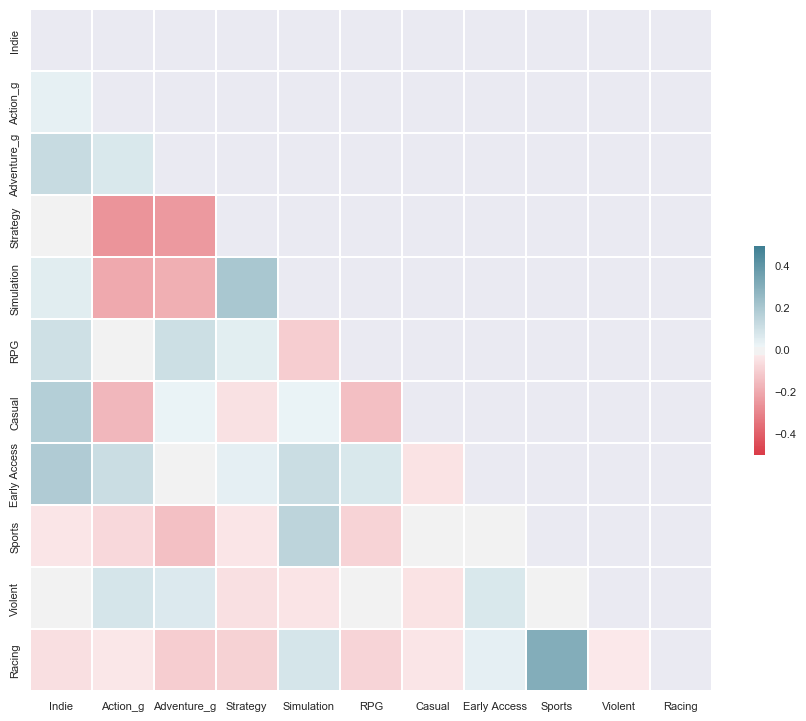

In [609]:
#generating a correlation plot
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .3}, ax=ax)
#none of the correlation nor the overlapping is very sigifnicant

Current size: [12.0, 9.0]


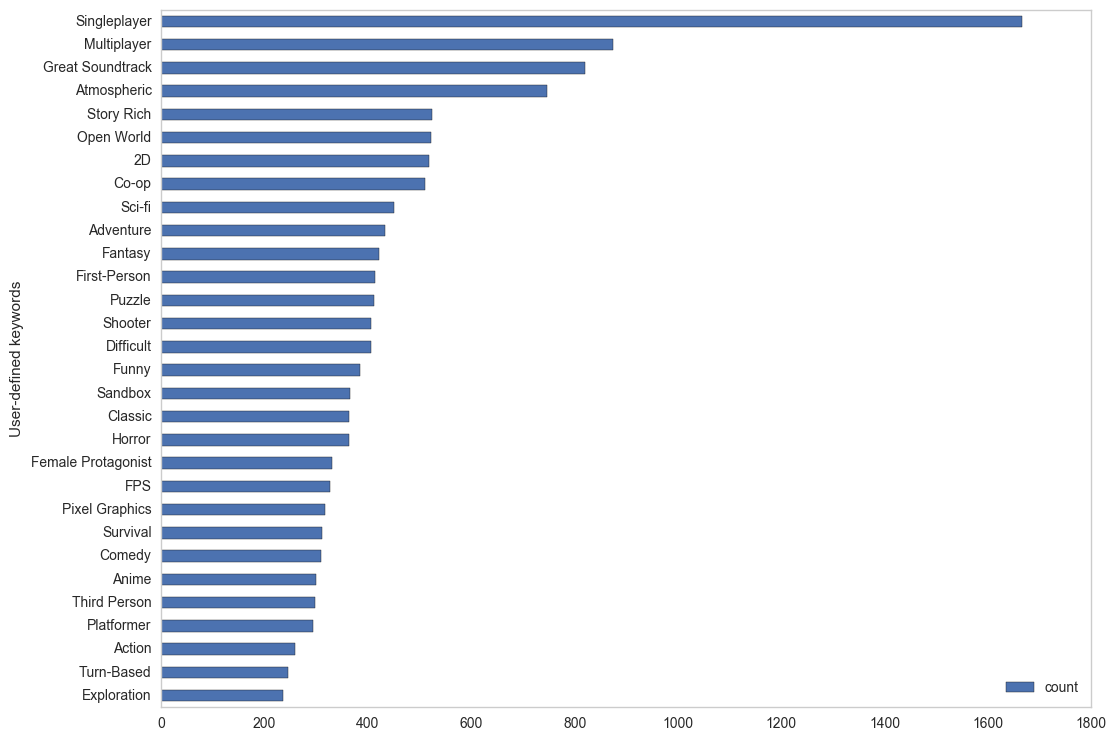

In [725]:
key[key["count"]>230].sort_values(by = "count",ascending=True).plot.barh(x="keywords")
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('User-defined keywords')

In [727]:
import plotly.plotly as py
import plotly.graph_objs as go
subset_key = key[key["count"]>230].sort_values(by="count")
data = [go.Bar(
            x=subset_key["count"],
            y=subset_key["keywords"],
            orientation = 'h')]
layout = go.Layout(
    title="User-defined Keywords",
    xaxis=dict(
        title="Keywords"),
    yaxis=dict(
        title='Counts'),autosize=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='horizontal-bar')

In [731]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'unique', 'Singleplayer', 'Multiplayer',
       'Great Soundtrack', 'Atmospheric', 'Story Rich', 'Open World', '2D',
       'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy', 'Puzzle',
       'First-Person', 'Shooter', 'Difficult', 'Funny', 'Classic',
       'Sandbox', 'Horror', 'Female Protagonist', 'FPS', 'Pixel Graphics',
       'Comedy', 'Survival', 'Third Person', 'Anime', 'Platformer',
       'Action_k', 'Turn-Based', 'Exploration', 'total_key', 'Indie',
       'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing', 'retention'], dtype=object)

In [804]:
names_k = [""]

In [809]:
def ttest_al(x,data):
    t1 = final_file[["all_time",x]].groupby(x).agg("mean")
    entry = [(x, t1.reset_index().iloc[1,1])]
    labels = ["keywords","avg_all_time"]
    record = pd.DataFrame.from_records(entry, columns =labels)
    data = data.append(record)

In [810]:
avg_all_time_k = pd.DataFrame(columns = ["keywords","avg_all_time"])
for i in names_k:
    print i
    ttest_al(i,avg_all_time_k)
    

Exploration
Turn-Based
Action


KeyError: "['Action'] not in index"

4267.4122448979588

In [750]:
testing_df = pd.DataFrame(columns = ["keywords","all_time"])

In [736]:
testing_df

,keywords,all_time


In [712]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

subset_key = key[key["count"]>230].sort_values(by="count")
y_count = subset_key["count"]
x_count = subset_key["keywords"]
y_all_time

y_net_worth = [93453.919999999998, 81666.570000000007, 69889.619999999995,
               78381.529999999999, 141395.29999999999, 92969.020000000004,
               66090.179999999993, 122379.3]
x_saving = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
            'United States', 'Belgium', 'Sweden', 'Switzerland']
x_net_worth = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
               'United States', 'Belgium', 'Sweden', 'Switzerland'
               ]
trace0 = go.Bar(
    x=y_saving,
    y=x_saving,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Household savings, percentage of household disposable income',
    orientation='h',
)
trace1 = go.Scatter(
    x=y_net_worth,
    y=x_net_worth,
    mode='lines+markers',
    line=dict(
        color='rgb(128, 0, 128)'),
    name='Household net worth, Million USD/capita',
)
layout = dict(
    title='Household savings & net worth for eight OECD countries',
    yaxis1=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis1=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(
        x=0.029,
        y=1.038,
        font=dict(
            size=10,
        ),
    ),
    margin=dict(
        l=100,
        r=20,
        t=70,
        b=70,
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn - 20000,
                            text='{:,}'.format(ydn) + 'M',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 3,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text='OECD "' +
                             '(2015), Household savings (indicator), ' +
                             'Household net worth (indicator). doi: ' +
                             '10.1787/cfc6f499-en (Accessed on 05 June 2015)',
                        font=dict(family='Arial', size=10,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
py.iplot(fig, filename='oecd-networth-saving-bar-line')

,keywords,count
66,Singleplayer,1665
246,Multiplayer,875
46,Great Soundtrack,821
197,Atmospheric,746
36,Story Rich,524
82,Open World,522
51,2D,518
176,Co-op,510
264,Sci-fi,451
40,Adventure,433


In [644]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
plotly.tools.set_credentials_file(username='jasonchiu0803', api_key='Jk1S0TST6AbhYxuAnYPD')

In [689]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'unique', 'Singleplayer', 'Multiplayer',
       'Great Soundtrack', 'Atmospheric', 'Story Rich', 'Open World', '2D',
       'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy', 'Puzzle',
       'First-Person', 'Shooter', 'Difficult', 'Funny', 'Classic',
       'Sandbox', 'Horror', 'Female Protagonist', 'FPS', 'Pixel Graphics',
       'Comedy', 'Survival', 'Third Person', 'Anime', 'Platformer',
       'Action_k', 'Turn-Based', 'Exploration', 'total_key', 'Indie',
       'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing', 'retention'], dtype=object)

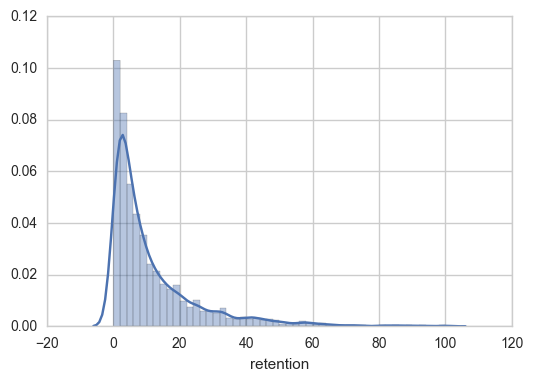

In [692]:
sns.distplot(final_file['retention'])

In [811]:
#correlation between keywords
df_k = final_file[["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich",
                 "Open World","2D","Co-op","Sci-fi","Fantasy","Adventure_k","Puzzle","First-Person","Shooter",
                 "Difficult","Funny","Classic","Sandbox","Horror","Female Protagonist",
                 "FPS","Pixel Graphics","Comedy","Survival","Third Person","Anime","Platformer","Action_k","Turn-Based",
                "Exploration"]]

In [812]:
col_name_k = df_k.columns.values
new_k = pd.DataFrame(columns = col_name_k, index = col_name_k)

In [813]:
a_k = col_name_k
for i in range(len(a_k)):
    j = i
    new_k.loc[col_name_k[i],col_name_k[j]]=1
    j = i + 1 
    while j < len(a_k):
        new_k.loc[col_name_k[i],col_name_k[j]] = ORs(col_name_k[i],col_name_k[j],df_k)
        j = j + 1 

In [814]:
for i in range(len(a_k)):
    j = i
    new_k.loc[col_name_k[i],col_name_k[j]]=1
    j = i + 1 
    while j < len(a_k):
        new_k.loc[col_name_k[j],col_name_k[i]] = ORs(col_name_k[j],col_name_k[i],df_k)
        j = j + 1 

In [815]:
pd.set_option('display.max_columns', 100)

In [816]:
new_k

,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Fantasy,Adventure_k,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration
Singleplayer,1,3.36,6.17,8.56,5.87,5.56,3.3,3.18,5.02,5.34,11.25,2.19,4.18,3.67,3.79,3.93,4.72,4.13,2.19,2.69,2.59,1.6,4.24,3.01,22.21,1.27,1.91,10.98,3.44,5.58
Multiplayer,3.36,1,1.24,1.42,0.61,4.65,0.67,29.09,2.32,1.03,3.54,0.29,4.5,5.17,0.93,2.48,1.7,3.69,1.25,0.45,6.52,0.61,1.61,3.7,2.77,0.42,0.64,2.62,1.2,0.96
Great Soundtrack,6.17,1.24,1,4.6,6.42,1.65,3.65,1.33,2.29,2.38,2.88,1.97,1.32,1.47,3.35,2.38,2.88,1.19,1.29,2.6,0.82,2.95,2.01,0.75,3.03,3.05,3.42,2.35,1.26,2.8
Atmospheric,8.56,1.42,4.6,1,9.98,4.3,1.28,1.61,2.89,2.31,3.74,2.37,6.16,2.67,2.74,1.14,3.15,1.9,5.91,1.84,2.81,0.76,1.05,3.25,6.04,0.62,1.37,2.72,0.77,7.89
Story Rich,5.87,0.61,6.42,9.98,1,2.23,1.27,0.58,2.16,4.03,3.7,2.07,1.89,1.33,1.17,1.15,2.67,0.77,3.06,3.98,1.17,1.01,1.64,1.08,4.98,3.3,0.9,1.83,1.62,3.68
Open World,5.56,4.65,1.65,4.3,2.23,1,0.57,4.13,1.96,1.76,4.9,0.54,4.04,2.42,0.87,2.16,1.2,16.5,1.51,0.87,2.78,0.5,1.61,8.04,8.1,0.54,0.64,3.36,0.75,7.46
2D,3.3,0.67,3.65,1.28,1.27,0.57,1,1.19,1.18,1.78,1.05,2.17,0.03,0.74,4.54,2.26,0.87,1.21,0.91,1.64,0.04,20.93,2.31,1.1,0.09,1.82,11.79,1.15,1.16,1.7
Co-op,3.18,29.09,1.33,1.61,0.58,4.13,1.19,1,1.76,1.38,3.21,0.43,3.38,4.85,1.11,2.74,1.14,3.08,1.68,0.69,4.97,1.05,2.41,4.6,3.11,0.4,1.19,2.17,0.45,0.97
Sci-fi,5.02,2.32,2.29,2.89,2.16,1.96,1.18,1.76,1,0.41,2.91,0.6,3.57,4.53,1.14,0.84,2.89,1.65,1.63,1.23,4.02,0.94,1,2.07,1.44,0.68,1.01,1.59,1.84,2.21
Fantasy,5.34,1.03,2.38,2.31,4.03,1.76,1.78,1.38,0.41,1,3.49,1.33,0.47,0.11,1.44,1.43,2.05,0.95,0.34,2.65,0.18,1.42,1.98,0.48,3.28,2.17,1.38,2.46,6.35,1.85


In [817]:
df_k.corr()

,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Fantasy,Adventure_k,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration
Singleplayer,1.000000,0.254059,0.346358,0.371973,0.274918,0.268526,0.201652,0.194709,2.395582e-01,0.238101,0.301306,0.125601,0.210061,0.193152,0.197007,0.196298,0.209894,0.196446,0.118975,0.139738,0.134473,0.069300,1.837134e-01,0.149149,0.272662,0.035265,0.090381,0.228864,0.145988,0.181689
Multiplayer,0.254059,1.000000,0.044502,0.069952,-0.077511,0.290381,-0.063025,0.565346,1.474272e-01,0.005313,0.222766,-0.147013,0.261663,0.283595,-0.010496,0.150497,0.082625,0.215747,0.033487,-0.094100,0.294841,-0.060927,6.865723e-02,0.202574,0.153029,-0.096380,-0.054355,0.135605,0.022563,-0.004571
Great Soundtrack,0.346358,0.044502,1.000000,0.316761,0.351695,0.088748,0.242457,0.048430,1.439060e-01,0.147369,0.184011,0.112109,0.043213,0.061245,0.206883,0.141793,0.171678,0.025237,0.037265,0.148421,-0.025168,0.166728,1.028411e-01,-0.036080,0.166558,0.168132,0.185260,0.118410,0.029245,0.139556
Atmospheric,0.371973,0.069952,0.316761,1.000000,0.433142,0.272986,0.040465,0.081412,1.849326e-01,0.139419,0.230360,0.142460,0.318412,0.163864,0.168352,0.018629,0.186224,0.098535,0.296741,0.089399,0.158903,-0.033570,6.318255e-03,0.180616,0.277820,-0.054068,0.041679,0.139373,-0.028752,0.288903
Story Rich,0.274918,-0.077511,0.351695,0.433142,1.000000,0.130398,0.035194,-0.066193,1.189533e-01,0.230363,0.215761,0.107881,0.093568,0.038968,0.021057,0.017786,0.145788,-0.028954,0.169925,0.210343,0.019177,0.000973,6.254927e-02,0.009157,0.241886,0.170823,-0.011061,0.073044,0.055599,0.172950
Open World,0.268526,0.290381,0.088748,0.272986,0.130398,1.000000,-0.068252,0.246934,1.026876e-01,0.082656,0.269164,-0.067188,0.229098,0.134524,-0.016679,0.112846,0.023090,0.475994,0.055321,-0.015848,0.146656,-0.064086,6.033524e-02,0.331690,0.327907,-0.056859,-0.042987,0.164497,-0.027024,0.287891
2D,0.201652,-0.063025,0.242457,0.040465,0.035194,-0.068252,1.000000,0.024701,2.327742e-02,0.084294,0.006218,0.115536,-0.169092,-0.035943,0.249398,0.119764,-0.015982,0.023950,-0.010594,0.064054,-0.145776,0.492310,1.138025e-01,0.010946,-0.129063,0.076341,0.390304,0.015269,0.015651,0.060713
Co-op,0.194709,0.565346,0.048430,0.081412,-0.066193,0.246934,0.024701,1.000000,8.323841e-02,0.044343,0.187812,-0.084293,0.194323,0.261440,0.013114,0.152260,0.016296,0.170176,0.070517,-0.037839,0.248374,0.005122,1.197597e-01,0.230959,0.159676,-0.077614,0.019602,0.096499,-0.062960,-0.002753
Sci-fi,0.239558,0.147427,0.143906,0.184933,0.118953,0.102688,0.023277,0.083238,1.000000e+00,-0.084316,0.163809,-0.053855,0.198704,0.241617,0.015852,-0.019767,0.153842,0.064973,0.062616,0.023605,0.205002,-0.006570,-3.278136e-16,0.093240,0.042374,-0.035880,0.000600,0.051358,0.068637,0.092330
Fantasy,0.238101,0.005313,0.147369,0.139419,0.230363,0.082656,0.084294,0.044343,-8.431623e-02,1.000000,0.193111,0.036052,-0.070598,-0.132453,0.046542,0.044380,0.094920,-0.005137,-0.086817,0.131666,-0.105902,0.039890,8.474826e-02,-0.061202,0.161390,0.096768,0.035276,0.108925,0.260264,0.067210


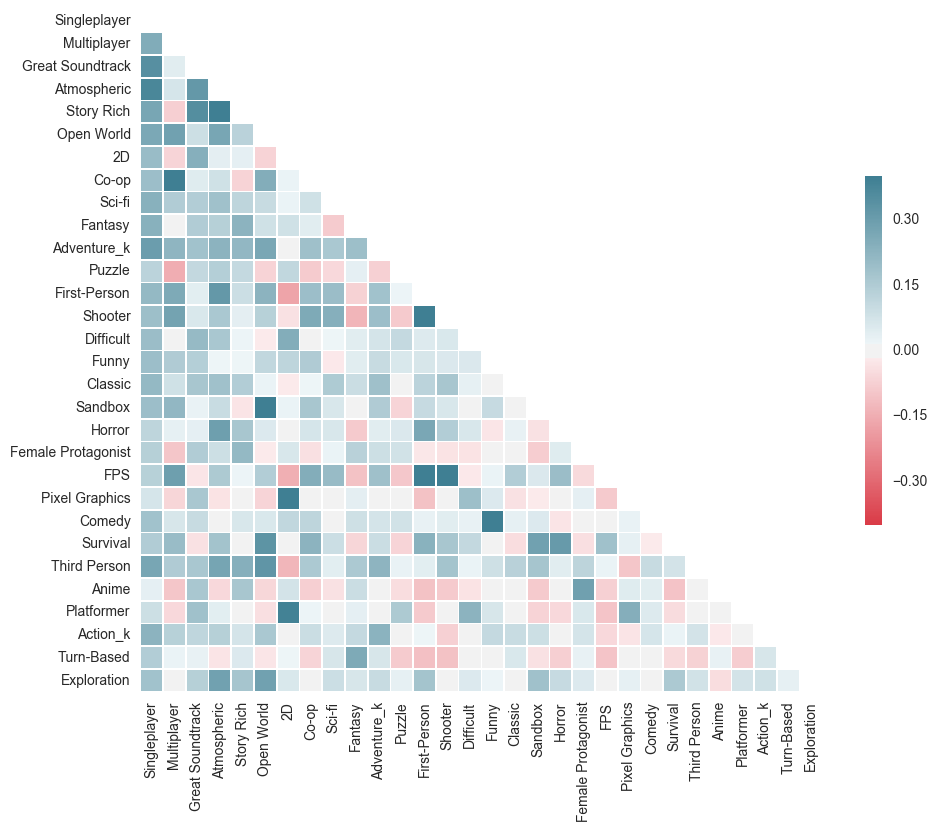

In [818]:
#generating a correlation plot
corr = df_k.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
#none of the correlation nor the overlapping is very sigifnicant

In [819]:
greater_k = 0
for i in range(len(a_k)):
    j = i + 1 
    while j < len(a_k):
        if new_k.loc[col_name_k[i],col_name_k[j]] > 1:
            greater_k = greater_k + 1
        j = j + 1 
greater_k_per = float(greater_k)/(float(sum(range(1,30)))-28)

In [820]:
greater_k_per

0.7936117936117936

In [821]:
(float(sum(range(1,29)))-28)

378.0

In [822]:
less_k = 0
for i in range(len(a_k)):
    j = i + 1 
    while j < len(a_k):
        if new_k.loc[col_name_k[i],col_name_k[j]] < 1:
            less_k = less_k + 1
        j = j + 1 
less_k_per = float(less_k)/(float(sum(range(1,30)))-28)

In [823]:
less_k_per

0.2727272727272727

top 28 keywords were included in the study:
73% were positively correlated with each other: meaning that the appearance of one keyword will increase the odds of the other odds: multiplayer & co-operation (all co-op games are multiplayer, but there are some competitive games), story-rich and atompheric, great soundtrack with atomspheric and story-rich => combining visual and music to create an immersive exeprience.
27% were negatively correlated with each other: meaning that the appearance of one keyword will decrease the odds of the other odds: puzzle and multiplayer, first-person, anime, playformer, and turn-based

In [824]:
test_list = ["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich","Open World","2D","Co-op",
             "Sci-fi","Adventure_k","Fantasy","Puzzle","First-Person","Shooter","Difficult","Funny","Classic",
             "Sandbox","Horror","Female Protagonist","FPS","Pixel Graphics","Comedy","Survival","Third Person",
             "Anime","Platformer","Action_k","Turn-Based","Exploration"]

In [825]:
len(test_list)

30

In [705]:
#insepecting all_time players/ 2 sample t-test/ p-value
import scipy
def ttest_al(x):
    print final_file[["all_time",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["all_time"][final_file[x]==0],final_file["all_time"][final_file[x]==1])[1]

In [706]:
for i in range(len(test_list)):
    ttest_al(test_list[i])
    print "="*50

                 all_time
Singleplayer             
0              801.317090
1             4598.210036
2.1183020195e-11
                all_time
Multiplayer             
0            1229.621260
1            6949.132723
5.42179481831e-20
                     all_time
Great Soundtrack             
0                 1935.442478
1                 5380.471341
7.34840578707e-08
                all_time
Atmospheric             
0            1503.175161
1            7082.110738
2.36438854925e-17
               all_time
Story Rich             
0           2470.698670
1           4719.904398
0.00287951028487
                all_time
Open World              
0            1376.599062
1           10102.436660
1.94708841959e-31
       all_time
2D             
0   3002.071596
1   2111.754352
0.240559073206
          all_time
Co-op             
0      1497.459160
1      9697.679764
2.13834300752e-27
           all_time
Sci-fi             
0       2382.146388
1       5602.314444
5.90980101582e-05
   

In [707]:
#insepecting retention relationship
def ttest_re(x):
    print final_file[["retention",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["retention"][final_file[x]==0],final_file["retention"][final_file[x]==1])[1]

Current size: [12.0, 9.0]


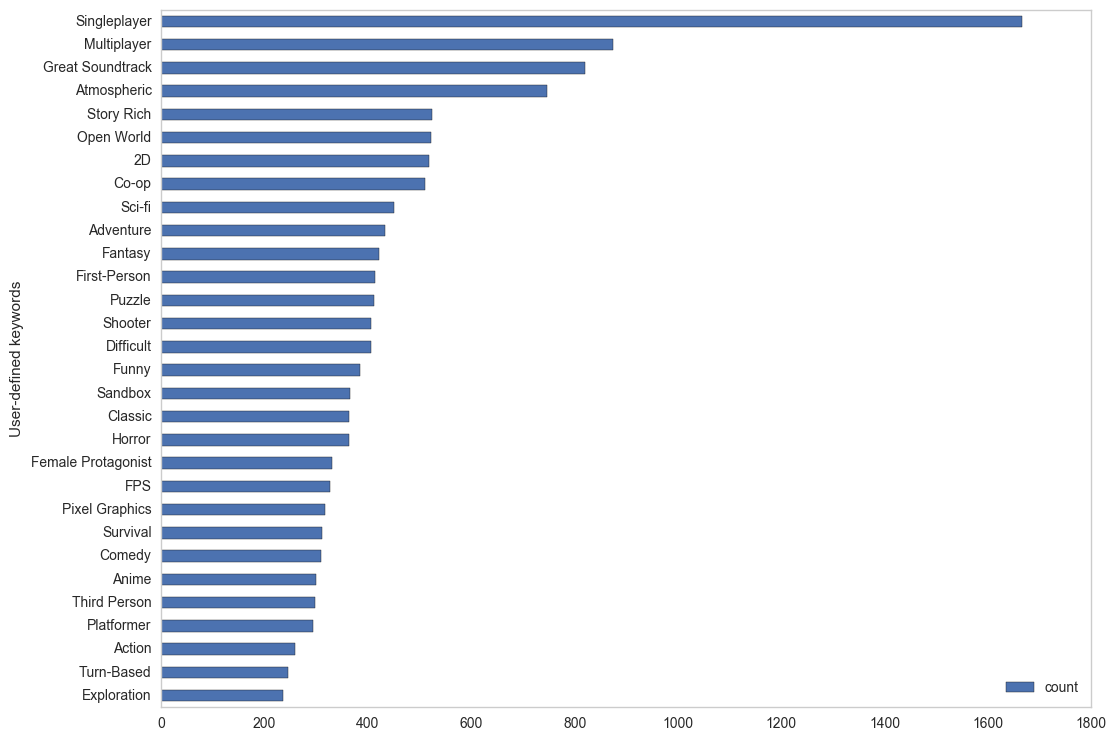

In [766]:
#matplot word count
key[key["count"]>230].sort_values(by = "count",ascending=True).plot.barh(x="keywords")
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('User-defined keywords')

In [768]:
#interactive word counts for keywords
import plotly.plotly as py
import plotly.graph_objs as go
subset_key = key[key["count"]>230].sort_values(by="count")
data = [go.Bar(
            x=subset_key["count"],
            y=subset_key["keywords"],
            orientation = 'h')]
layout = go.Layout(
    title="User-defined Keywords",
    xaxis=dict(
        title="Counts"),
    yaxis=dict(
        title='User-defined Keywrods'),autosize=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='horizontal-bar')

In [904]:
def avg_al(x, list_name):
    t1 = final_file[["all_time",x]].groupby(x).agg("mean")
    t2 = scipy.stats.ttest_ind(final_file["all_time"][final_file[x]==0],final_file["all_time"][final_file[x]==1])[1]
    if x == "Action_k":
        x = "Action"
    if x == "Adventure_k":
        x = "Adventure"
    number = round(t1.reset_index().iloc[1,1],2)
    number_without = round(t1.reset_index().iloc[0,1],2)
    number_p = round(t2,8)
    entry = (x, number, number_without, number_p)
    list_name.append(entry)

In [905]:
avg_all_time_k = list()
for i in range(len(test_list)):
    avg_al(test_list[i],avg_all_time_k)

In [907]:
labels = ["keywords","a_at","a_wo","p"]
all_time_k = pd.DataFrame.from_records(avg_all_time_k, columns =labels)
all_time_k
all_info = pd.merge(subset_key,all_time_k,how="inner",on = "keywords")

In [908]:
all_info

,keywords,count,a_at,a_wo,p
0,Exploration,236,8758.03,2364.83,0.000000e+00
1,Turn-Based,246,4267.41,2730.36,1.423782e-01
2,Action,258,7949.28,2388.64,5.000000e-08
3,Platformer,294,1828.09,2960.34,2.413385e-01
4,Third Person,298,9110.85,2184.75,0.000000e+00
5,Anime,299,1134.57,3036.66,4.729754e-02
6,Comedy,309,4050.90,2719.48,1.588837e-01
7,Survival,312,9403.00,2116.92,0.000000e+00
8,Pixel Graphics,317,2082.53,2940.67,3.584442e-01
9,FPS,326,9671.74,2048.19,0.000000e+00


In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

subset_key = key[key["count"]>230].sort_values(by="count")
y_count = subset_key["count"]
x_count = subset_key["keywords"]
y_all_time

y_net_worth = [93453.919999999998, 81666.570000000007, 69889.619999999995,
               78381.529999999999, 141395.29999999999, 92969.020000000004,
               66090.179999999993, 122379.3]
x_saving = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
            'United States', 'Belgium', 'Sweden', 'Switzerland']
x_net_worth = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
               'United States', 'Belgium', 'Sweden', 'Switzerland'
               ]
trace0 = go.Bar(
    x=y_saving,
    y=x_saving,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Household savings, percentage of household disposable income',
    orientation='h',
)
trace1 = go.Scatter(
    x=y_net_worth,
    y=x_net_worth,
    mode='lines+markers',
    line=dict(
        color='rgb(128, 0, 128)'),
    name='Household net worth, Million USD/capita',
)
layout = dict(
    title='Household savings & net worth for eight OECD countries',
    yaxis1=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis1=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(
        x=0.029,
        y=1.038,
        font=dict(
            size=10,
        ),
    ),
    margin=dict(
        l=100,
        r=20,
        t=70,
        b=70,
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn - 20000,
                            text='{:,}'.format(ydn) + 'M',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 3,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text='OECD "' +
                             '(2015), Household savings (indicator), ' +
                             'Household net worth (indicator). doi: ' +
                             '10.1787/cfc6f499-en (Accessed on 05 June 2015)',
                        font=dict(family='Arial', size=10,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
py.iplot(fig, filename='oecd-networth-saving-bar-line')

In [899]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np

y_saving = [1.3586, 2.2623000000000002, 4.9821999999999997, 6.5096999999999996,
            7.4812000000000003, 7.5133000000000001, 15.2148, 17.520499999999998
            ]
y_net_worth = [93453.919999999998, 81666.570000000007, 69889.619999999995,
               78381.529999999999, 141395.29999999999, 92969.020000000004,
               66090.179999999993, 122379.3]
x_saving = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
            'United States', 'Belgium', 'Sweden', 'Switzerland']
x_net_worth = ['Japan', 'United Kingdom', 'Canada', 'Netherlands',
               'United States', 'Belgium', 'Sweden', 'Switzerland'
               ]
trace0 = go.Bar(
    x=y_saving,
    y=x_saving,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Household savings, percentage of household disposable income',
    orientation='h',
)
trace1 = go.Scatter(
    x=y_net_worth,
    y=x_net_worth,
    mode='lines+markers',
    line=dict(
        color='rgb(128, 0, 128)'),
    name='Household net worth, Million USD/capita',
)
layout = dict(
    title='Household savings & net worth for eight OECD countries',
    yaxis1=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis1=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(
        x=0.029,
        y=1.038,
        font=dict(
            size=10,
        ),
    ),
    margin=dict(
        l=100,
        r=20,
        t=70,
        b=70,
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn - 20000,
                            text='{:,}'.format(ydn) + 'M',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 3,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text='OECD "' +
                             '(2015), Household savings (indicator), ' +
                             'Household net worth (indicator). doi: ' +
                             '10.1787/cfc6f499-en (Accessed on 05 June 2015)',
                        font=dict(family='Arial', size=10,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
py.iplot(fig, filename='oecd-networth-saving-bar-line')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jasonchiu0803/0 or inside your plot.ly account where it is named 'oecd-networth-saving-bar-line'
